# Hyperparameter Comparison for Semi-supervised Learning

Notebook này thực hiện **Yêu cầu 3** của bài tập:

- So sánh ảnh hưởng của tham số **τ (confidence threshold)**
- So sánh ảnh hưởng của **kích thước tập nhãn ban đầu**
- Áp dụng cho:
  - Self-training
  - Co-training
- Đánh giá bằng **Accuracy** và **F1-macro** trên tập test

# CELL 2 – Import & Config chung

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Luôn xác định root project = AIR_GUARD
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

# Add project root vào PYTHONPATH
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)

from src.semi_supervised_library import (
    SemiDataConfig,
    SelfTrainingConfig,
    CoTrainingConfig,
    run_self_training,
    run_co_training
)

# ===============================
# GLOBAL CONFIG
# ===============================
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"
VAL_FRAC = 0.20
RANDOM_STATE = 42

PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

PROJECT_ROOT = d:\KHMT_16-01\Data Mining\air_guard


# CELL 3 – Load dataset

In [2]:
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (420768, 56)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,SO2_lag24,NO2_lag24,CO_lag24,O3_lag24,TEMP_lag24,PRES_lag24,DEWP_lag24,RAIN_lag24,WSPM_lag24,is_labeled
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


# ===============================
# PHẦN A — SELF-TRAINING
# ===============================

# CELL 4 – Self-training với τ = 0.9

In [3]:
data_cfg = SemiDataConfig(
    cutoff=CUTOFF,
    random_state=RANDOM_STATE
)

st_cfg_tau_09 = SelfTrainingConfig(
    tau=0.9,
    max_iter=10,
    min_new_per_iter=20,
    val_frac=VAL_FRAC
)

out_st_09 = run_self_training(df, data_cfg, st_cfg_tau_09)

print("Self-training (tau=0.9)")
print("Accuracy:", out_st_09["test_metrics"]["accuracy"])
print("F1-macro:", out_st_09["test_metrics"]["f1_macro"])

Self-training (tau=0.9)
Accuracy: 0.589046847819567
F1-macro: 0.5343258092284096


# CELL 5 — Self-training với τ = 0.8 (thử nghiệm)

In [4]:
st_cfg_tau_08 = SelfTrainingConfig(
    tau=0.8,
    max_iter=10,
    min_new_per_iter=20,
    val_frac=VAL_FRAC
)

out_st_08 = run_self_training(df, data_cfg, st_cfg_tau_08)

print("Self-training (tau=0.8)")
print("Accuracy:", out_st_08["test_metrics"]["accuracy"])
print("F1-macro:", out_st_08["test_metrics"]["f1_macro"])

Self-training (tau=0.8)
Accuracy: 0.5940855377601824
F1-macro: 0.5166876119048376


# CELL 6 — Bảng so sánh Self-training theo τ

In [5]:
self_tau_compare_df = pd.DataFrame([
    {
        "Method": "Self-training (tau = 0.9)",
        "Accuracy": out_st_09["test_metrics"]["accuracy"],
        "F1_macro": out_st_09["test_metrics"]["f1_macro"]
    },
    {
        "Method": "Self-training (tau = 0.8)",
        "Accuracy": out_st_08["test_metrics"]["accuracy"],
        "F1_macro": out_st_08["test_metrics"]["f1_macro"]
    }
])

self_tau_compare_df


,Method,Accuracy,F1_macro
0,Self-training (tau = 0.9),0.589047,0.534326
1,Self-training (tau = 0.8),0.594086,0.516688


# CELL 7 — Biểu đồ ảnh hưởng của τ (Self-training)

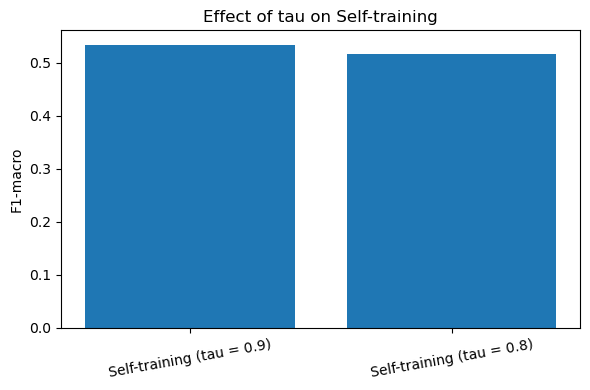

In [6]:
plt.figure(figsize=(6,4))
plt.bar(self_tau_compare_df["Method"], self_tau_compare_df["F1_macro"])
plt.ylabel("F1-macro")
plt.title("Effect of tau on Self-training")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()


# ===============================
# PHẦN B — THAY ĐỔI KÍCH THƯỚC TẬP NHÃN BAN ĐẦU
# ===============================

# CELL 8 — Self-training với tập nhãn ban đầu LỚN HƠN

In [7]:
# Giữ nguyên tau = 0.9, nhưng tăng số nhãn ban đầu (ít thiếu nhãn hơn)
data_cfg_more_label = SemiDataConfig(
    cutoff=CUTOFF,
    random_state=RANDOM_STATE,
)

st_cfg_more_label = SelfTrainingConfig(
    tau=0.9,
    max_iter=10,
    min_new_per_iter=20,
    val_frac=VAL_FRAC
)

out_st_more_label = run_self_training(df, data_cfg_more_label, st_cfg_more_label)

print("Self-training (more initial labels)")
print("Accuracy:", out_st_more_label["test_metrics"]["accuracy"])
print("F1-macro:", out_st_more_label["test_metrics"]["f1_macro"])


Self-training (more initial labels)
Accuracy: 0.589046847819567
F1-macro: 0.5343258092284096


# CELL 9 — Bảng so sánh theo kích thước tập nhãn ban đầu

In [8]:
label_size_compare_df = pd.DataFrame([
    {
        "Setting": "Default initial labels",
        "Accuracy": out_st_09["test_metrics"]["accuracy"],
        "F1_macro": out_st_09["test_metrics"]["f1_macro"]
    },
    {
        "Setting": "More initial labels",
        "Accuracy": out_st_more_label["test_metrics"]["accuracy"],
        "F1_macro": out_st_more_label["test_metrics"]["f1_macro"]
    }
])

label_size_compare_df


,Setting,Accuracy,F1_macro
0,Default initial labels,0.589047,0.534326
1,More initial labels,0.589047,0.534326


# CELL 10 — Biểu đồ ảnh hưởng của kích thước tập nhãn ban đầu

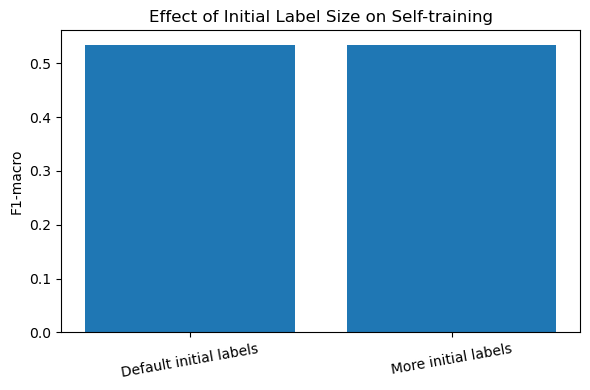

In [9]:
plt.figure(figsize=(6,4))
plt.bar(label_size_compare_df["Setting"], label_size_compare_df["F1_macro"])
plt.ylabel("F1-macro")
plt.title("Effect of Initial Label Size on Self-training")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()


# ===============================
# PHẦN C — CO-TRAINING
# ===============================

# CELL 11 — Định nghĩa 2 view

In [10]:
# View A – Pollution features
VIEW1_COLS = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3"]

# View B – Meteorological features
VIEW2_COLS = ["TEMP", "PRES", "DEWP", "RAIN", "WSPM"]


# CELL 12 — Co-training với τ = 0.9

In [11]:
ct_cfg_tau_09 = CoTrainingConfig(
    tau=0.9,
    max_iter=10,
    max_new_per_iter=500,
    min_new_per_iter=20,
    val_frac=VAL_FRAC
)

out_ct_09 = run_co_training(
    df,
    data_cfg,
    ct_cfg_tau_09,
    view1_cols=VIEW1_COLS,
    view2_cols=VIEW2_COLS
)

print("Co-training (tau=0.9)")
print("Accuracy:", out_ct_09["test_metrics"]["accuracy"])
print("F1-macro:", out_ct_09["test_metrics"]["f1_macro"])


Co-training (tau=0.9)
Accuracy: 0.4703976965988843
F1-macro: 0.3393540364398587


# CELL 13 — Co-training với τ = 0.95

In [12]:
ct_cfg_tau_095 = CoTrainingConfig(
    tau=0.95,
    max_iter=10,
    max_new_per_iter=500,
    min_new_per_iter=20,
    val_frac=VAL_FRAC
)

out_ct_095 = run_co_training(
    df,
    data_cfg,
    ct_cfg_tau_095,
    view1_cols=VIEW1_COLS,
    view2_cols=VIEW2_COLS
)

print("Co-training (tau=0.95)")
print("Accuracy:", out_ct_095["test_metrics"]["accuracy"])
print("F1-macro:", out_ct_095["test_metrics"]["f1_macro"])


Co-training (tau=0.95)
Accuracy: 0.4649991002339392
F1-macro: 0.32761672586576696


# CELL 14 — Bảng so sánh Co-training theo τ

In [13]:
co_tau_compare_df = pd.DataFrame([
    {
        "Method": "Co-training (tau = 0.9)",
        "Accuracy": out_ct_09["test_metrics"]["accuracy"],
        "F1_macro": out_ct_09["test_metrics"]["f1_macro"]
    },
    {
        "Method": "Co-training (tau = 0.95)",
        "Accuracy": out_ct_095["test_metrics"]["accuracy"],
        "F1_macro": out_ct_095["test_metrics"]["f1_macro"]
    }
])

co_tau_compare_df


,Method,Accuracy,F1_macro
0,Co-training (tau = 0.9),0.470398,0.339354
1,Co-training (tau = 0.95),0.464999,0.327617


# CELL 15 — Biểu đồ ảnh hưởng của τ (Co-training)

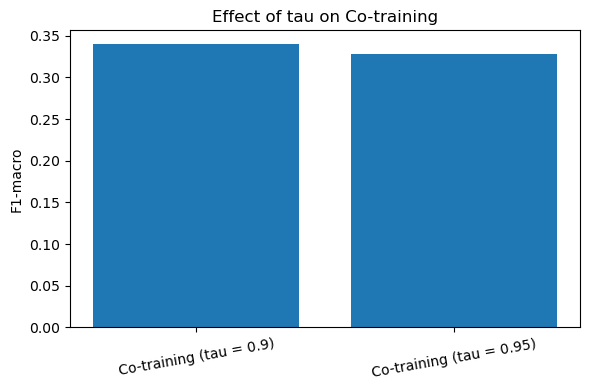

In [14]:
plt.figure(figsize=(6,4))
plt.bar(co_tau_compare_df["Method"], co_tau_compare_df["F1_macro"])
plt.ylabel("F1-macro")
plt.title("Effect of tau on Co-training")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()


# ===============================
# PHẦN D — Co-training với view theo tập trạm
# ===============================

# CELL 16 — Chuẩn bị view theo tập trạm

In [15]:
# ============================================
# CO-TRAINING WITH STATION-BASED VIEWS
# ============================================

# Lấy danh sách trạm
stations = df["station"].dropna().unique()
stations = sorted(stations)

# Chia trạm thành 2 nhóm (50% - 50%)
mid = len(stations) // 2
stations_A = stations[:mid]
stations_B = stations[mid:]

print("Number of stations in View A:", len(stations_A))
print("Number of stations in View B:", len(stations_B))


Number of stations in View A: 6
Number of stations in View B: 6


# CELL 17 — Tạo 2 view dữ liệu theo trạm

In [16]:
# View A: dữ liệu từ nhóm trạm A
df_viewA = df[df["station"].isin(stations_A)].copy()

# View B: dữ liệu từ nhóm trạm B
df_viewB = df[df["station"].isin(stations_B)].copy()

print("View A shape:", df_viewA.shape)
print("View B shape:", df_viewB.shape)

View A shape: (210384, 56)
View B shape: (210384, 56)


# CELL 18 — Chạy Co-training với view theo trạm

In [17]:
VIEW1_COLS = [
    "PM2.5", "PM10", "SO2", "NO2", "CO", "O3",
    "TEMP", "PRES", "DEWP", "RAIN", "WSPM"
]

VIEW2_COLS = VIEW1_COLS.copy()  # cùng feature, khác dữ liệu

ct_cfg_station = CoTrainingConfig(
    tau=0.9,
    max_iter=10,
    max_new_per_iter=500,
    min_new_per_iter=20,
    val_frac=VAL_FRAC,
)

# Gộp lại để chạy co-training
df_station_combined = pd.concat([df_viewA, df_viewB]).sort_index()

out_ct_station = run_co_training(
    df_station_combined,
    data_cfg,
    ct_cfg_station,
    view1_cols=VIEW1_COLS,
    view2_cols=VIEW2_COLS
)

print("Co-training (station-based views)")
print("Accuracy:", out_ct_station["test_metrics"]["accuracy"])
print("F1-macro:", out_ct_station["test_metrics"]["f1_macro"])


Co-training (station-based views)
Accuracy: 0.5062683702237418
F1-macro: 0.4133842779276542


# CELL 19 — So sánh Co-training: feature-view vs station-view

In [18]:
station_compare_df = pd.DataFrame([
    {
        "Method": "Co-training (feature-based views)",
        "Accuracy": out_ct_09["test_metrics"]["accuracy"],
        "F1_macro": out_ct_09["test_metrics"]["f1_macro"]
    },
    {
        "Method": "Co-training (station-based views)",
        "Accuracy": out_ct_station["test_metrics"]["accuracy"],
        "F1_macro": out_ct_station["test_metrics"]["f1_macro"]
    }
])

station_compare_df


,Method,Accuracy,F1_macro
0,Co-training (feature-based views),0.470398,0.339354
1,Co-training (station-based views),0.506268,0.413384


# CELL 20 — Biểu đồ so sánh hai cách tách view

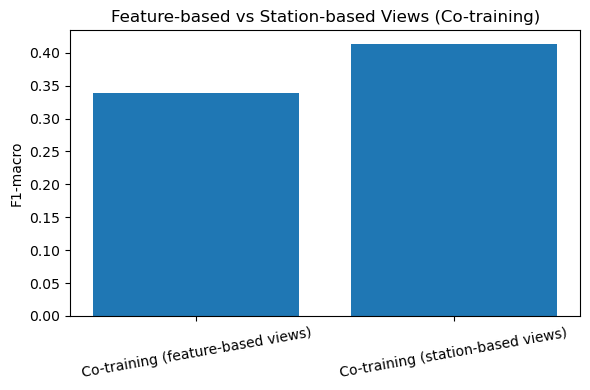

In [19]:
plt.figure(figsize=(6,4))
plt.bar(
    station_compare_df["Method"],
    station_compare_df["F1_macro"]
)
plt.ylabel("F1-macro")
plt.title("Feature-based vs Station-based Views (Co-training)")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()
